# Connect to google account

In [944]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount("/content/data")

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [945]:
# 모듈 Import
import random
import numpy as np # 행렬 계산에 사용하는 모듈
import pandas as pd # 데이터 처리와 분석을 위한 모듈
import matplotlib.pyplot as plt # 데이터 시각화를 위한 모듈. 2D, 3D 그릴 때 사용
import seaborn as sns # 데이터 시각화를 위한 모듈. 두 데이터의 관계를 볼때 사용
from datetime import datetime, timedelta
from tqdm.auto import tqdm

In [946]:
# 딕셔너리를 간편하게 사용하는 것을 도와준다. 모델 class 처럼 사용 가능
# dot을 이용해 객체를 불러 사용. JSON 다룰때 유용.
import easydict
args = easydict.EasyDict()

# path
args.default_path = "/content/data/MyDrive/플레이데이터 데이터엔지니어링 28기/Dacon/KMU/data/" # 메인 경로
args.apply_train_path = args.default_path + "apply_train.csv" # train 데이터 경로
args.company_path = args.default_path + "company.csv"
args.recruitment_path = args.default_path + "recruitment.csv"
args.resume_certificate_path = args.default_path + "resume_certificate.csv"
args.resume_education_path = args.default_path + "resume_education.csv"
args.resume_language_path = args.default_path + "resume_language.csv"
args.resume_path = args.default_path + "resume.csv"

args.default_submission_path = args.default_path + "sample_submission.csv" # 예측결과(제출파일) 경로

# 데이터 분석을 위한 변수들
# # 난수 생성 제어 => 같은 코드를 실행해도 동일한 결과를 얻기 위해서 설정
# 데이터 분할 및 모델 초기화 때 유용.
args.random_state = 42
args.results = [] # 결과 저장 리스트

In [947]:
args.submission_path = args.default_path + "result/submission_Model_2.csv" # 결과 저장 파일
args.save_results = args.default_path+"result/model_results_Model_2.json" # 결과 저장 json

In [948]:
def recall5(answer_df, submission_df):

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # submission의 예측이 각각 5개인지 확인
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # submission의 예측된 값들에 null값이 있는지 확인
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # 예측값에 중복이 있는지 확인
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    # primary_col 즉 resume_seq가 양측에 있는지 확인 후 남김
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    #
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    #recall = np.mean(individual_recalls)
    recall = max(individual_recalls)
    return recall

# File Load

In [949]:
apply_train_df = pd.read_csv(args.apply_train_path) # apply_train -> DataFrame화
company_df = pd.read_csv(args.company_path) # company -> DataFrame화
recruitment_df = pd.read_csv(args.recruitment_path) # recruitment -> DataFrame화
resume_certificate_df = pd.read_csv(args.resume_certificate_path) # resume_certificate -> DataFreame화
resume_education_df = pd.read_csv(args.resume_education_path) # resume_education -> DataFrame화
resume_language_df = pd.read_csv(args.resume_language_path) # resume_language -> DataFrame화
resume_df = pd.read_csv(args.resume_path) # resume -> DataFrame화


In [950]:
apply_train = apply_train_df.copy()
company = company_df.copy()
recruitment = recruitment_df.copy()
resume_certificate = resume_certificate_df.copy()
resume_education = resume_education_df.copy()
resume_language = resume_language_df.copy()
resume = resume_df.copy()

# 탐색

## merged_recruitment 생성

In [951]:
# recruitment, company 정렬(recruitment_seq 기준)
company = company.sort_values(by = "recruitment_seq")
recruitment = recruitment.sort_values(by = "recruitment_seq")

In [952]:
# merged_recruitment = recruitment, company merge
merged_recruitment = pd.merge(recruitment, company, on='recruitment_seq', how='left')
merged_recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


## merged_recruitment 탐색 & drop

In [953]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   address_seq2       100 non-null    float64
 3   address_seq3       9 non-null      float64
 4   career_end         6695 non-null   int64  
 5   career_start       6695 non-null   int64  
 6   check_box_keyword  6695 non-null   object 
 7   education          6695 non-null   int64  
 8   major_task         6695 non-null   int64  
 9   qualifications     6695 non-null   int64  
 10  text_keyword       707 non-null    object 
 11  company_type_seq   2377 non-null   float64
 12  supply_kind        2377 non-null   float64
 13  employee           2377 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 784.6+ KB


In [954]:
merged_recruitment.describe()

,address_seq1,address_seq2,address_seq3,career_end,career_start,education,major_task,qualifications,company_type_seq,supply_kind,employee
count,6694.000000,100.000000,9.000000,6695.0,6695.0,6695.000000,6695.000000,6695.000000,2377.000000,2377.000000,2377.000000
mean,3.103675,7.900000,16.555556,0.0,0.0,3.081703,2.277521,1.317401,2.944468,344.090029,217.696676
std,0.955459,7.399836,6.424778,0.0,0.0,0.753074,1.242267,0.477852,1.739406,131.232212,331.153073
min,1.000000,1.000000,3.000000,0.0,0.0,2.000000,1.000000,0.000000,2.000000,100.000000,0.000000
25%,3.000000,1.000000,18.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,41.000000
50%,3.000000,5.000000,20.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,145.000000
75%,3.000000,14.000000,20.000000,0.0,0.0,4.000000,2.000000,2.000000,4.000000,402.000000,300.000000
max,20.000000,20.000000,20.000000,0.0,0.0,6.000000,10.000000,2.000000,9.000000,605.000000,12223.000000


In [955]:
(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

recruitment_seq      0.000000
career_end           0.000000
career_start         0.000000
check_box_keyword    0.000000
education            0.000000
major_task           0.000000
qualifications       0.000000
address_seq1         0.000149
company_type_seq     0.644959
supply_kind          0.644959
employee             0.644959
text_keyword         0.894399
address_seq2         0.985063
address_seq3         0.998656
dtype: float64

In [956]:
merged_recruitment_drop_col = ['address_seq2','address_seq3', 'career_start', 'career_end', 'text_keyword', 'company_type_seq', 'supply_kind', 'employee']
merged_recruitment = merged_recruitment.drop(merged_recruitment_drop_col, axis=1)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 366.1+ KB


In [957]:
def extract_main_codes(check_box_keyword):
    # 코드를 세미콜론으로 분리하고, 각 코드의 앞 두 자리를 추출
    if pd.isna(check_box_keyword):
        return []
    return list(set(code[:2] for code in check_box_keyword.split(';')))

# 모든 메인 코드를 담을 집합 생성
all_main_codes = set()

# 각 행의 메인 코드 추출 및 집합에 추가
for keywords in merged_recruitment['check_box_keyword'].dropna():
    all_main_codes.update(extract_main_codes(keywords))

# 각 메인 코드에 대한 컬럼을 생성하고, 해당 코드가 있으면 1, 없으면 0 할당
for main_code in all_main_codes:
    merged_recruitment[f'main_code_{main_code}'] = merged_recruitment['check_box_keyword'].apply(
        lambda x: 1 if main_code in extract_main_codes(x) else 0
    )

# 필요없는 check_box_keyword 드랍
merged_recruitment = merged_recruitment.drop('check_box_keyword', axis=1)

In [958]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recruitment_seq  6695 non-null   object 
 1   address_seq1     6694 non-null   float64
 2   education        6695 non-null   int64  
 3   major_task       6695 non-null   int64  
 4   qualifications   6695 non-null   int64  
 5   main_code_28     6695 non-null   int64  
 6   main_code_31     6695 non-null   int64  
 7   main_code_26     6695 non-null   int64  
 8   main_code_22     6695 non-null   int64  
 9   main_code_27     6695 non-null   int64  
 10  main_code_30     6695 non-null   int64  
 11  main_code_29     6695 non-null   int64  
 12  main_code_21     6695 non-null   int64  
 13  main_code_23     6695 non-null   int64  
 14  main_code_25     6695 non-null   int64  
dtypes: float64(1), int64(13), object(1)
memory usage: 836.9+ KB


In [959]:
fillna_col = ['address_seq1']

for col in fillna_col: #for문을 돌면서 각 컬럼에 대한 최빈값으로 채움
  col_mode = merged_recruitment[col].mode().values[0]
  merged_recruitment[col].fillna(col_mode, inplace=True)


#employee는
#merged_recruitment['employee'] = merged_recruitment.groupby(['qualifications'])['employee'].apply(lambda x: x.fillna(x.median())).reset_index(drop=True)

(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

recruitment_seq    0.0
address_seq1       0.0
education          0.0
major_task         0.0
qualifications     0.0
main_code_28       0.0
main_code_31       0.0
main_code_26       0.0
main_code_22       0.0
main_code_27       0.0
main_code_30       0.0
main_code_29       0.0
main_code_21       0.0
main_code_23       0.0
main_code_25       0.0
dtype: float64

In [960]:
'''
#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환
merged_recruitment_object = merged_recruitment.select_dtypes(exclude=np.number)
object_cols = list(merged_recruitment_object.columns)

for col in object_cols:
  merged_recruitment[col] = merged_recruitment[col].astype('category')

#형 변환 확인
merged_recruitment.info()
'''

"\n#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환\nmerged_recruitment_object = merged_recruitment.select_dtypes(exclude=np.number)\nobject_cols = list(merged_recruitment_object.columns)\n\nfor col in object_cols:\n  merged_recruitment[col] = merged_recruitment[col].astype('category')\n\n#형 변환 확인\nmerged_recruitment.info()\n"

## merged_resume 생성

### resume

In [961]:
# resume 정렬 (resume_seq 기준)
resume = resume.sort_values(by='resume_seq')
resume.head()

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,job_code_seq3,career_month,career_job_code
1690,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,NaN,0,NaN
3979,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,NaN,73,기타 공공;개인서비스
5648,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,NaN,113,섬유;봉제;가방;의류
1367,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,NaN,27,섬유;봉제;가방;의류
5242,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,NaN,0,NaN


In [962]:
resume.isnull().sum() / len(resume)

resume_seq         0.000000
reg_date           0.000000
updated_date       0.000000
degree             0.000000
graduate_date      0.000000
hope_salary        0.000000
last_salary        0.000000
text_keyword       0.022990
job_code_seq1      0.000000
job_code_seq2      0.941052
job_code_seq3      0.977953
career_month       0.000000
career_job_code    0.089366
dtype: float64

In [963]:
resume.drop(['reg_date','updated_date','text_keyword', 'job_code_seq2', 'job_code_seq3', 'career_job_code', 'graduate_date'], axis = 1, inplace=True)
resume.head()

,resume_seq,degree,hope_salary,last_salary,job_code_seq1,career_month
1690,U00001,4,1500.0,1500.0,재료·화학·섬유·의복,0
3979,U00002,4,0.0,0.0,재료·화학·섬유·의복,73
5648,U00003,4,0.0,0.0,재료·화학·섬유·의복,113
1367,U00004,4,0.0,0.0,재료·화학·섬유·의복,27
5242,U00005,4,0.0,0.0,재료·화학·섬유·의복,0


In [964]:
mapping = {
    '재료·화학·섬유·의복': 1,
    '디자인': 2,
    '경영·기획·회계·사무': 3,
    '영업·판매·TM': 4,
    '건설·기계·전기·전자': 5,
    '전문·교육·자격':5,
    'IT·게임'            :6,
    '기타 직종'             :7,
    '문화·예술·신문·방송'       :8
}
resume['job_code_seq1'] = resume['job_code_seq1'].map(mapping)
resume.head()

,resume_seq,degree,hope_salary,last_salary,job_code_seq1,career_month
1690,U00001,4,1500.0,1500.0,1,0
3979,U00002,4,0.0,0.0,1,73
5648,U00003,4,0.0,0.0,1,113
1367,U00004,4,0.0,0.0,1,27
5242,U00005,4,0.0,0.0,1,0


In [965]:
resume['is_newbie'] = resume['career_month'].apply(lambda x: 0 if x < 12 else 1)
resume.head()

,resume_seq,degree,hope_salary,last_salary,job_code_seq1,career_month,is_newbie
1690,U00001,4,1500.0,1500.0,1,0,0
3979,U00002,4,0.0,0.0,1,73,1
5648,U00003,4,0.0,0.0,1,113,1
1367,U00004,4,0.0,0.0,1,27,1
5242,U00005,4,0.0,0.0,1,0,0


### resume_certificate

In [966]:
# resume_certificate 정렬 (resume_seq 기준)
resume_certificate = resume_certificate.sort_values(by='resume_seq')
# certificate_contents에 결측값이 존재하는 행 제거
resume_certificate = resume_certificate.dropna(subset=['certificate_contents'])
# 이력서번호(resume_seq)기준으로 groupby
# 이력서번호(resume_seq)의 해당하는 자격증들을 세미콜론(;)으로 join해서 적용(apply)
#resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()

In [967]:
resume_certificate.head(10)

,resume_seq,certificate_contents
6855,U00002,자동차 운전면허 (2종 보통)
6458,U00003,운전면허2종보통
4424,U00003,컬러리스트 기사
7553,U00003,워드프로세서 1급
1509,U00004,정보처리기능사
905,U00004,유통관리사 2급
3524,U00004,MOS EXCEL 2003 EXPERT
1705,U00006,운전면허 1종 보통
2888,U00006,문서실무사1급
1404,U00006,유통관리사 2급


In [968]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re

# 주어진 데이터를 데이터프레임으로 생성

df = resume_certificate[~resume_certificate['certificate_contents'].str.contains('운전|워드프로세서|컴퓨터활용능력|mos|office|itq|한자')]

# 텍스트 전처리 함수 (모든 공백과 특수 문자 제거, 숫자 제거하지 않음)
def preprocess_text(text):
    # 모든 공백과 특수 문자 제거
    text = re.sub(r'[^a-zA-Z가-힣0-9]', '', text)

    # 모든 영문자를 소문자로 변환
    text = text.lower()

    return text

# 'certificate_contents' 열에 전처리 함수 적용
df['certificate_contents'] = df['certificate_contents'].apply(preprocess_text)

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['certificate_contents'])

# K-means 클러스터링
kmeans = KMeans(n_clusters=11, random_state=args.random_state)
kmeans.fit(tfidf_matrix)

# 클러스터 결과를 데이터프레임에 추가
df['cluster'] = kmeans.labels_

# 결과 확인
print(df.head())

     resume_seq certificate_contents  cluster
4424     U00003              컬러리스트기사        7
1509     U00004              정보처리기능사        8
905      U00004              유통관리사2급        6
3524     U00004   mosexcel2003expert        0
2888     U00006              문서실무사1급        0


<ipython-input-968-2fe467c341b3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certificate_contents'] = df['certificate_contents'].apply(preprocess_text)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-968-2fe467c341b3>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_


In [969]:
df['cluster'].value_counts()

0     5523
6      294
1      275
3      248
7      221
9      209
4      185
5      107
8       82
2       49
10      13
Name: cluster, dtype: int64

In [970]:
cluster_mode = df.groupby('cluster')['certificate_contents'].agg(lambda x: x.mode().iat[0])
cluster_mode

#컬러리스트기사랑 컬러리스트 산업기사랑 다르다.. !!

cluster
0           gtq포토샵1급
1       컴퓨터그래픽스운용기능사
2        유통관리사2급국가공인
3          컬러리스트산업기사
4        패션머천다이징산업기사
5          mosmaster
6            유통관리사2급
7            컬러리스트기사
8            정보처리기능사
9             샵마스터3급
10    컴퓨터그래픽스운용기능사필기
Name: certificate_contents, dtype: object

In [971]:
# 필요한 클러스터 범위 지정 (1부터 10까지)
cluster_range = range(1, 11)

# cluster_1에서 cluster_10까지의 컬럼 생성
for cluster_num in cluster_range:
    df[f'certificate_{cluster_num}'] = (df['cluster'] == cluster_num).astype(int)

# cluster 컬럼 제거
df.drop(['certificate_contents','cluster'], axis=1, inplace=True)

# 결과 확인
df

<ipython-input-971-feb6b1f8372e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'certificate_{cluster_num}'] = (df['cluster'] == cluster_num).astype(int)
<ipython-input-971-feb6b1f8372e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'certificate_{cluster_num}'] = (df['cluster'] == cluster_num).astype(int)
<ipython-input-971-feb6b1f8372e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,resume_seq,certificate_1,certificate_2,certificate_3,certificate_4,certificate_5,certificate_6,certificate_7,certificate_8,certificate_9,certificate_10
4424,U00003,0,0,0,0,0,0,1,0,0,0
1509,U00004,0,0,0,0,0,0,0,1,0,0
905,U00004,0,0,0,0,0,1,0,0,0,0
3524,U00004,0,0,0,0,0,0,0,0,0,0
2888,U00006,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
666,U08480,1,0,0,0,0,0,0,0,0,0
6980,U08480,0,0,0,0,0,0,1,0,0,0
7043,U08480,0,0,0,0,0,0,0,0,0,0
7386,U08482,1,0,0,0,0,0,0,0,0,0


In [972]:
resume_certificate = df.groupby('resume_seq').sum().reset_index()
resume_certificate

,resume_seq,certificate_1,certificate_2,certificate_3,certificate_4,certificate_5,certificate_6,certificate_7,certificate_8,certificate_9,certificate_10
0,U00003,0,0,0,0,0,0,1,0,0,0
1,U00004,0,0,0,0,0,1,0,1,0,0
2,U00006,0,0,0,0,0,1,0,0,0,0
3,U00007,0,0,0,0,0,0,0,0,0,0
4,U00009,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3680,U08466,0,0,0,0,0,0,1,0,0,0
3681,U08472,0,0,0,0,0,0,0,0,0,0
3682,U08479,1,0,0,0,0,0,0,0,0,0
3683,U08480,1,0,0,0,0,0,1,0,0,0


### resume_education

In [973]:
# resume_education 정렬 (resume_seq 기준)
resume_education = resume_education.sort_values(by='resume_seq')
resume_education = resume_education[['resume_seq', 'univ_location', 'univ_score']]

In [974]:
resume_education.isnull().sum() / len(resume_education)

resume_seq       0.0
univ_location    0.0
univ_score       0.0
dtype: float64

In [975]:
resume_education['univ_score'].describe()

count    8482.000000
mean       71.380350
std        20.418688
min         0.000000
25%        70.000000
50%        80.000000
75%        80.000000
max       100.000000
Name: univ_score, dtype: float64

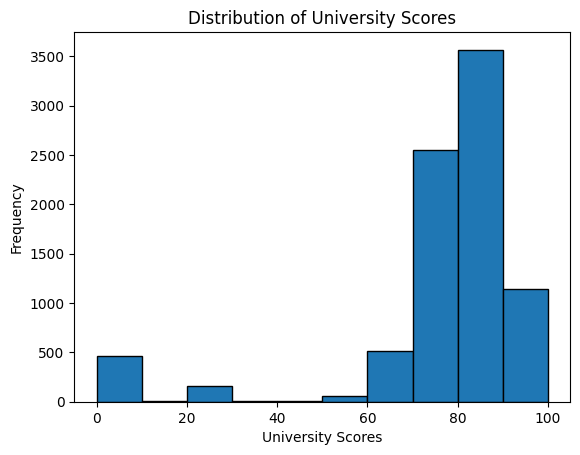

In [976]:
univ_scores = resume_education['univ_score']

# 히스토그램을 그립니다.
plt.hist(univ_scores, bins=10, edgecolor='k')  # bins는 히스토그램의 구간 수를 나타냅니다.
plt.xlabel('University Scores')
plt.ylabel('Frequency')
plt.title('Distribution of University Scores')
plt.show()

### resume_language

In [977]:
# resume_language 정렬 (resume_seq 기준)
resume_language = resume_language.sort_values(by='resume_seq')

In [978]:
def has_language(x, language):
    return int(language in x.values)

for language in resume_language['language'].unique():
    new_col_name = f'language_{language}'
    resume_language[new_col_name] = resume_language.groupby('resume_seq')['language'].transform(lambda x: has_language(x, language))

resume_language.drop_duplicates(subset='resume_seq', keep='first', inplace=True)

In [979]:
resume_language['lang_score'] = resume_language.groupby('language')['score'].rank(pct=True) > 0.5
resume_language['lang_score'] = resume_language['lang_score'].astype('int')

In [980]:
resume_language.head()

,resume_seq,language,exam_name,score,language_2,language_4,language_3,language_9,language_8,lang_score
45,U00004,2,11,661.62,1,0,0,0,0,0
701,U00005,2,4,873.74,1,0,0,0,0,1
205,U00039,2,4,848.48,1,0,0,0,0,1
645,U00054,2,4,909.09,1,0,0,0,0,1
769,U00067,2,2,20.00,1,0,0,0,0,0


In [981]:
resume_language.drop(['language','exam_name','score'], axis = 1, inplace=True)
resume_language.head()

,resume_seq,language_2,language_4,language_3,language_9,language_8,lang_score
45,U00004,1,0,0,0,0,0
701,U00005,1,0,0,0,0,1
205,U00039,1,0,0,0,0,1
645,U00054,1,0,0,0,0,1
769,U00067,1,0,0,0,0,0


### resume 데이터 merge

In [982]:
# merged_resume = resume, resume_certificate, resume_education, resume_language
merged_resume = pd.merge(resume, resume_certificate, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_education, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_language, on='resume_seq', how='left')
merged_resume

,resume_seq,degree,hope_salary,last_salary,job_code_seq1,career_month,is_newbie,certificate_1,certificate_2,certificate_3,...,certificate_9,certificate_10,univ_location,univ_score,language_2,language_4,language_3,language_9,language_8,lang_score
0,U00001,4,1500.0,1500.0,1,0,0,NaN,NaN,NaN,...,NaN,NaN,17,20.0,NaN,NaN,NaN,NaN,NaN,NaN
1,U00002,4,0.0,0.0,1,73,1,NaN,NaN,NaN,...,NaN,NaN,3,90.0,NaN,NaN,NaN,NaN,NaN,NaN
2,U00003,4,0.0,0.0,1,113,1,0.0,0.0,0.0,...,0.0,0.0,17,90.0,NaN,NaN,NaN,NaN,NaN,NaN
3,U00004,4,0.0,0.0,1,27,1,0.0,0.0,0.0,...,0.0,0.0,5,70.0,1.0,0.0,0.0,0.0,0.0,0.0
4,U00005,4,0.0,0.0,1,0,0,NaN,NaN,NaN,...,NaN,NaN,0,50.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,4,0.0,2700.0,1,60,1,NaN,NaN,NaN,...,NaN,NaN,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8478,U08479,3,2500.0,2300.0,1,59,1,1.0,0.0,0.0,...,0.0,0.0,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8479,U08480,4,0.0,0.0,2,0,0,1.0,0.0,0.0,...,0.0,0.0,10,80.0,NaN,NaN,NaN,NaN,NaN,NaN
8480,U08481,4,0.0,2700.0,1,8,0,NaN,NaN,NaN,...,NaN,NaN,5,60.0,NaN,NaN,NaN,NaN,NaN,NaN


## merged_resume 탐색 & drop

In [983]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   resume_seq      8482 non-null   object 
 1   degree          8482 non-null   int64  
 2   hope_salary     8482 non-null   float64
 3   last_salary     8482 non-null   float64
 4   job_code_seq1   8482 non-null   int64  
 5   career_month    8482 non-null   int64  
 6   is_newbie       8482 non-null   int64  
 7   certificate_1   3685 non-null   float64
 8   certificate_2   3685 non-null   float64
 9   certificate_3   3685 non-null   float64
 10  certificate_4   3685 non-null   float64
 11  certificate_5   3685 non-null   float64
 12  certificate_6   3685 non-null   float64
 13  certificate_7   3685 non-null   float64
 14  certificate_8   3685 non-null   float64
 15  certificate_9   3685 non-null   float64
 16  certificate_10  3685 non-null   float64
 17  univ_location   8482 non-null   i

In [984]:
for col in merged_resume: #for문을 돌면서 각 컬럼을 0으로 채움. 어차피 0아니면 1인 값에서 null 값은 0으로 해석됨
  merged_resume[col].fillna(0, inplace=True)

(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq        0.0
language_9        0.0
language_3        0.0
language_4        0.0
language_2        0.0
univ_score        0.0
univ_location     0.0
certificate_10    0.0
certificate_9     0.0
certificate_8     0.0
certificate_7     0.0
language_8        0.0
certificate_6     0.0
certificate_4     0.0
certificate_3     0.0
certificate_2     0.0
certificate_1     0.0
is_newbie         0.0
career_month      0.0
job_code_seq1     0.0
last_salary       0.0
hope_salary       0.0
degree            0.0
certificate_5     0.0
lang_score        0.0
dtype: float64

In [985]:
'''
#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환
merged_resume_object = merged_resume.select_dtypes(exclude=np.number)
object_cols = list(merged_resume_object.columns)

for col in object_cols:
  merged_resume[col] = merged_resume[col].astype('category')

#형 변환 확인
merged_resume.info()
'''

"\n#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환\nmerged_resume_object = merged_resume.select_dtypes(exclude=np.number)\nobject_cols = list(merged_resume_object.columns)\n\nfor col in object_cols:\n  merged_resume[col] = merged_resume[col].astype('category')\n\n#형 변환 확인\nmerged_resume.info()\n"

## merged_total EDA

### merged_total 생성

In [986]:
_merged_total = pd.merge(apply_train, merged_recruitment, left_on='recruitment_seq', right_on='recruitment_seq', how='left')
_merged_total = pd.merge(_merged_total, merged_resume, left_on='resume_seq', right_on='resume_seq', how='left')
merged_total = _merged_total
merged_total.head()

,resume_seq,recruitment_seq,address_seq1,education,major_task,qualifications,main_code_28,main_code_31,main_code_26,main_code_22,...,certificate_9,certificate_10,univ_location,univ_score,language_2,language_4,language_3,language_9,language_8,lang_score
0,U05833,R03838,3.0,3,2,1,0,0,0,1,...,0.0,0.0,3,60.0,0.0,0.0,0.0,0.0,0.0,0.0
1,U06456,R02144,3.0,3,2,1,0,0,0,1,...,0.0,0.0,10,70.0,0.0,0.0,0.0,0.0,0.0,0.0
2,U07807,R01877,3.0,3,2,1,0,0,0,0,...,1.0,0.0,15,80.0,0.0,0.0,0.0,0.0,0.0,0.0
3,U04842,R02463,3.0,4,2,1,0,0,0,0,...,0.0,0.0,3,80.0,0.0,0.0,0.0,0.0,0.0,0.0
4,U08336,R00112,3.0,3,8,1,0,0,0,0,...,0.0,0.0,17,70.0,0.0,0.0,0.0,0.0,0.0,0.0


In [987]:
merged_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57946 entries, 0 to 57945
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resume_seq       57946 non-null  object 
 1   recruitment_seq  57946 non-null  object 
 2   address_seq1     57946 non-null  float64
 3   education        57946 non-null  int64  
 4   major_task       57946 non-null  int64  
 5   qualifications   57946 non-null  int64  
 6   main_code_28     57946 non-null  int64  
 7   main_code_31     57946 non-null  int64  
 8   main_code_26     57946 non-null  int64  
 9   main_code_22     57946 non-null  int64  
 10  main_code_27     57946 non-null  int64  
 11  main_code_30     57946 non-null  int64  
 12  main_code_29     57946 non-null  int64  
 13  main_code_21     57946 non-null  int64  
 14  main_code_23     57946 non-null  int64  
 15  main_code_25     57946 non-null  int64  
 16  degree           57946 non-null  int64  
 17  hope_salary 

### (X) qualifications 의미 검증

<ipython-input-988-ea6ee53bdac7>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(merged_total['qualifications'], merged_total['hope_salary'], cmap='viridis')


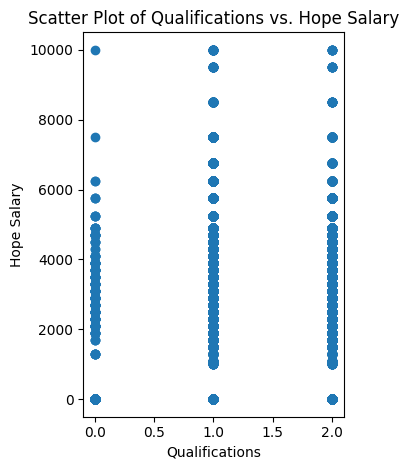

In [988]:
# 첫 번째 산점도 (qualification vs. hope_salary)
plt.subplot(1, 2, 1)
plt.scatter(merged_total['qualifications'], merged_total['hope_salary'], cmap='viridis')
plt.xlabel('Qualifications')
plt.ylabel('Hope Salary')
plt.title('Scatter Plot of Qualifications vs. Hope Salary')

plt.tight_layout()
plt.show()

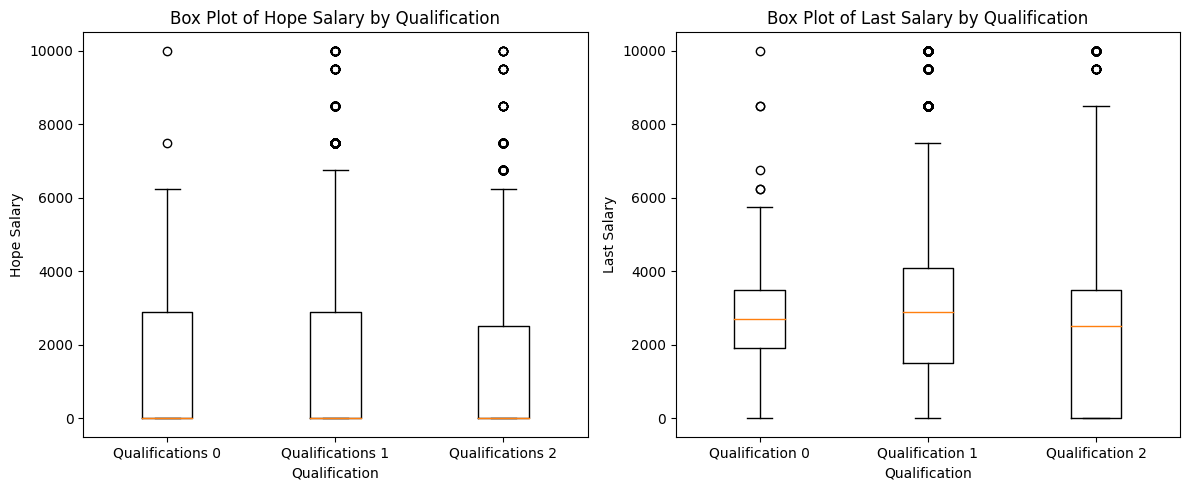

In [989]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.boxplot([merged_total[merged_total['qualifications'] == 0]['hope_salary'],
             merged_total[merged_total['qualifications'] == 1]['hope_salary'],
             merged_total[merged_total['qualifications'] == 2]['hope_salary']],
            labels=['Qualifications 0', 'Qualifications 1', 'Qualifications 2'])
plt.xlabel('Qualification')
plt.ylabel('Hope Salary')
plt.title('Box Plot of Hope Salary by Qualification')

# 'qualification'과 'last_salary'의 박스 플롯 그리기
plt.subplot(1, 2, 2)
plt.boxplot([merged_total[merged_total['qualifications'] == 0]['last_salary'],
             merged_total[merged_total['qualifications'] == 1]['last_salary'],
             merged_total[merged_total['qualifications'] == 2]['last_salary']],
            labels=['Qualification 0', 'Qualification 1', 'Qualification 2'])
plt.xlabel('Qualification')
plt.ylabel('Last Salary')
plt.title('Box Plot of Last Salary by Qualification')

plt.tight_layout()
plt.show()

qualifications와 연봉이 비례하지는 않는다...

In [990]:
median_hope_salary = merged_total.groupby('recruitment_seq')['hope_salary'].median().reset_index()

# 결과 확인
median_hope_salary

,recruitment_seq,hope_salary
0,R00001,0.0
1,R00002,0.0
2,R00003,0.0
3,R00004,0.0
4,R00005,0.0
...,...,...
6690,R06691,1650.0
6691,R06692,0.0
6692,R06693,0.0
6693,R06694,0.0


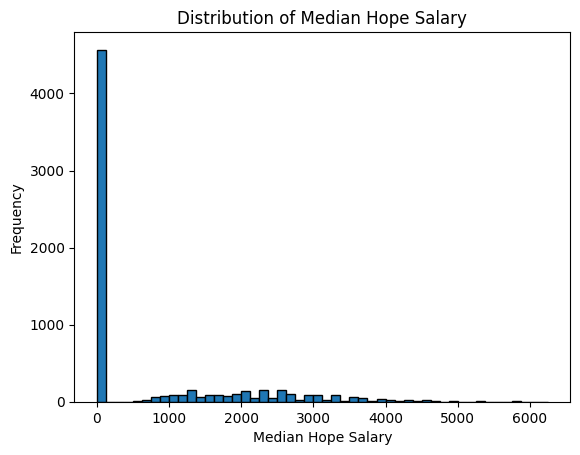

In [991]:
plt.hist(median_hope_salary['hope_salary'], bins=50, edgecolor='k')
plt.xlabel('Median Hope Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Median Hope Salary')
plt.show()

- 한 공고에 지원한 구직자들의 희망연봉 (중간값) 을 알아보면 그 기업이 어느정도 수준인지 알 수 있을 것 같았다.
- 그러나 희망연봉이 0인 케이스가 많다. 연봉은 협상으로 하려는 지원자가 대부분인 것이다.

### (O) company_level 생성

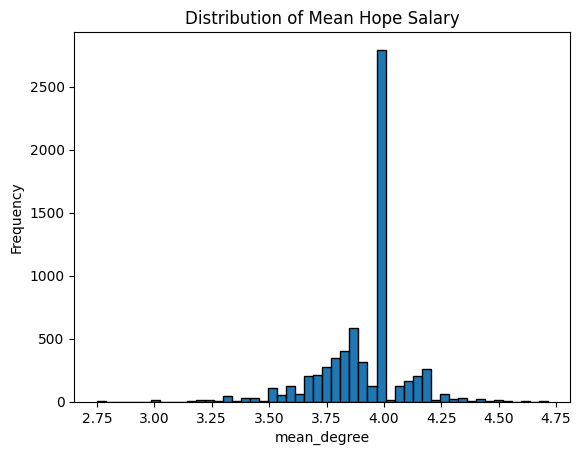

In [992]:
mean_degree = merged_total.groupby('recruitment_seq')['degree'].mean().reset_index()

# 결과 확인
plt.hist(mean_degree['degree'], bins=50, edgecolor='k')
plt.xlabel('mean_degree')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Hope Salary')
plt.show()

한 기업에 지원한 지원자들의 평균 학력을 보면 그 기업의 수준을 예측할 수 있을 것이다. 대부분의 기업들이 4년제 학사를 요구한다 (degree=4가 학사라는 가정하에.. 5=석사 6= 박사)

어쨌든 4, 4.4 기준으로 구간화하여 3등분한다. (중소,중견,대기업)

In [993]:
mean_degree.head()

,recruitment_seq,degree
0,R00001,3.909091
1,R00002,4.000000
2,R00003,4.000000
3,R00004,3.800000
4,R00005,3.800000


In [994]:
mean_degree['recruitment_seq'].nunique()
#모든 공고에 대한 값이 당연하게도 존재한다.

6695

In [995]:
mean_degree['company_level'] = mean_degree['degree'].apply(lambda x: 1 if x < 4.0 else (3 if x > 4.4 else 2))

In [996]:
mean_degree['company_level'].value_counts() / len(mean_degree)

2    0.553398
1    0.443913
3    0.002689
Name: company_level, dtype: float64

In [997]:
mean_degree.drop('degree', axis=1, inplace=True)
merged_recruitment = pd.merge(merged_recruitment, mean_degree, on='recruitment_seq', how='left')
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recruitment_seq  6695 non-null   object 
 1   address_seq1     6695 non-null   float64
 2   education        6695 non-null   int64  
 3   major_task       6695 non-null   int64  
 4   qualifications   6695 non-null   int64  
 5   main_code_28     6695 non-null   int64  
 6   main_code_31     6695 non-null   int64  
 7   main_code_26     6695 non-null   int64  
 8   main_code_22     6695 non-null   int64  
 9   main_code_27     6695 non-null   int64  
 10  main_code_30     6695 non-null   int64  
 11  main_code_29     6695 non-null   int64  
 12  main_code_21     6695 non-null   int64  
 13  main_code_23     6695 non-null   int64  
 14  main_code_25     6695 non-null   int64  
 15  company_level    6695 non-null   int64  
dtypes: float64(1), int64(14), object(1)
memory usage: 889.2+ KB


### (O) is_for_newbie 생성

In [998]:
mode_career_month = merged_total.groupby('recruitment_seq')['last_salary'].agg(lambda x: x.mode().iloc[0]).reset_index()

# is_for_newbie 컬럼 생성
mode_career_month['is_for_newbie'] = mode_career_month['last_salary'].apply(lambda x: 0 if x != 0 else 1)

# 결과 확인
mode_career_month

,recruitment_seq,last_salary,is_for_newbie
0,R00001,4100.0,0
1,R00002,0.0,1
2,R00003,2300.0,0
3,R00004,0.0,1
4,R00005,2900.0,0
...,...,...,...
6690,R06691,0.0,1
6691,R06692,3300.0,0
6692,R06693,0.0,1
6693,R06694,0.0,1


- 0이면 신입 포지션이고, 1이면 경력 포지션일 것이다!
- 물론 연봉정보에 민감해서 0으로 나타낸 사람도 있겠지만.. 무시할만한 수준이라고 판단했다

In [999]:
mode_career_month['is_for_newbie'].value_counts()

1    4360
0    2335
Name: is_for_newbie, dtype: int64

In [1000]:
mode_career_month.drop('last_salary', axis=1, inplace=True)
merged_recruitment = pd.merge(merged_recruitment, mode_career_month, on='recruitment_seq', how='left')
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recruitment_seq  6695 non-null   object 
 1   address_seq1     6695 non-null   float64
 2   education        6695 non-null   int64  
 3   major_task       6695 non-null   int64  
 4   qualifications   6695 non-null   int64  
 5   main_code_28     6695 non-null   int64  
 6   main_code_31     6695 non-null   int64  
 7   main_code_26     6695 non-null   int64  
 8   main_code_22     6695 non-null   int64  
 9   main_code_27     6695 non-null   int64  
 10  main_code_30     6695 non-null   int64  
 11  main_code_29     6695 non-null   int64  
 12  main_code_21     6695 non-null   int64  
 13  main_code_23     6695 non-null   int64  
 14  main_code_25     6695 non-null   int64  
 15  company_level    6695 non-null   int64  
 16  is_for_newbie    6695 non-null   int64  
dtypes: float64(1),

### (O) def : is_fit 생성

In [1001]:
# 'education'과 'degree' 컬럼을 조합하여 그룹화하고 카운트 계산
combination_counts = merged_total.groupby(['education', 'degree']).size().reset_index(name='count')
combination_counts = combination_counts.sort_values(by='count', ascending=False)

# 결과 확인
combination_counts

,education,degree,count
7,3,4,20912
12,4,4,16914
2,2,4,12633
6,3,3,1602
1,2,3,1021
11,4,3,913
8,3,5,844
13,4,5,832
5,3,2,727
3,2,5,525


- 대부분의 경우 education(요구학위)보다 degree(구직자 학력)이 높거나 같다..
- education보다 degree가 낮은걸 추천하면 안된다.
- 마지막에 output할 때 for문에서 검증을 해야한다.

In [1002]:
def compare_education_degree(df):
    """
    주어진 데이터프레임 내의 'education'와 'degree' 컬럼을 비교하여 조건에 따라 True 또는 False를 반환합니다.

    Parameters:
    df (pd.DataFrame): 입력 데이터프레임.

    Returns:
    pd.Series: 'education'와 'degree'를 비교한 결과 (True 또는 False)로 이루어진 시리즈.
    """
    return df['education'] > df['degree']

#나중에 활용방식에 따라 이 함수를 1, 0값이 나오도록 수정해줘도 됨
#1, 0값이 나오도록 수정하려면 결과 값에 int를 씌우면 될 것

### (O) def : newbie_out 생성

In [1003]:
def check_newbie_eligibility(df):
    """
    주어진 데이터프레임 내의 'is_newbie'와 'is_for_newbie' 컬럼을 비교하여 조건에 따라 True 또는 False를 반환합니다.

    Parameters:
    df (pd.DataFrame): 입력 데이터프레임.

    Returns:
    pd.Series: 조건에 따른 결과 (True 또는 False)로 이루어진 시리즈.
    """
    return (df['is_newbie'] == 0) & (df['is_for_newbie'] == 1)

#나중에 활용방식에 따라 이 함수를 1, 0값이 나오도록 수정해줘도 됨
#1, 0값이 나오도록 수정하려면 결과 값에 int를 씌우면 될 것

## Scaling

In [1004]:
merged_recruitment.info()
#이쪽에는 scaling할 값 없음

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recruitment_seq  6695 non-null   object 
 1   address_seq1     6695 non-null   float64
 2   education        6695 non-null   int64  
 3   major_task       6695 non-null   int64  
 4   qualifications   6695 non-null   int64  
 5   main_code_28     6695 non-null   int64  
 6   main_code_31     6695 non-null   int64  
 7   main_code_26     6695 non-null   int64  
 8   main_code_22     6695 non-null   int64  
 9   main_code_27     6695 non-null   int64  
 10  main_code_30     6695 non-null   int64  
 11  main_code_29     6695 non-null   int64  
 12  main_code_21     6695 non-null   int64  
 13  main_code_23     6695 non-null   int64  
 14  main_code_25     6695 non-null   int64  
 15  company_level    6695 non-null   int64  
 16  is_for_newbie    6695 non-null   int64  
dtypes: float64(1),

In [1005]:
merged_resume.info()
#home_salary, last_salary, career_month 스케일링

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   resume_seq      8482 non-null   object 
 1   degree          8482 non-null   int64  
 2   hope_salary     8482 non-null   float64
 3   last_salary     8482 non-null   float64
 4   job_code_seq1   8482 non-null   int64  
 5   career_month    8482 non-null   int64  
 6   is_newbie       8482 non-null   int64  
 7   certificate_1   8482 non-null   float64
 8   certificate_2   8482 non-null   float64
 9   certificate_3   8482 non-null   float64
 10  certificate_4   8482 non-null   float64
 11  certificate_5   8482 non-null   float64
 12  certificate_6   8482 non-null   float64
 13  certificate_7   8482 non-null   float64
 14  certificate_8   8482 non-null   float64
 15  certificate_9   8482 non-null   float64
 16  certificate_10  8482 non-null   float64
 17  univ_location   8482 non-null   i

In [1006]:
merged_resume.describe()

,degree,hope_salary,last_salary,job_code_seq1,career_month,is_newbie,certificate_1,certificate_2,certificate_3,certificate_4,...,certificate_9,certificate_10,univ_location,univ_score,language_2,language_4,language_3,language_9,language_8,lang_score
count,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,...,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000
mean,3.938222,1395.095496,2505.706201,1.240274,69.408984,0.815256,0.032422,0.005777,0.029238,0.021811,...,0.024640,0.001533,6.651733,71.380350,0.081585,0.008253,0.006838,0.001061,0.000118,0.048691
std,0.440764,1865.951253,2010.082733,0.657135,63.547948,0.388113,0.177127,0.075791,0.168484,0.146074,...,0.155036,0.039121,5.272027,20.418688,0.273747,0.090474,0.082414,0.032559,0.010858,0.215235
min,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,2700.000000,1.000000,53.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2700.000000,3700.000000,1.000000,108.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,10.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,10000.000000,10000.000000,8.000000,432.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,19.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1007]:
rs_scaling_col = ['hope_salary', 'last_salary', 'career_month']
rs_not_scaling_col = list(set(merged_resume.columns) - set(rs_scaling_col) - set(['resume_seq']) )

In [1008]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
_scaled_rs = std.fit_transform(merged_resume[rs_scaling_col])

In [1009]:
tmp = pd.DataFrame(
    _scaled_rs,
    columns = rs_scaling_col
)
_merged_resume = pd.concat(
    [merged_resume[rs_not_scaling_col].reset_index(drop=True), tmp.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)

_merged_resume['resume_seq'] = merged_resume['resume_seq']

merged_resume = _merged_resume

In [1010]:
merged_resume[rs_scaling_col]

,hope_salary,last_salary,career_month
0,0.056224,-0.500360,-1.092295
1,-0.747703,-1.246642,0.056512
2,-0.747703,-1.246642,0.685995
3,-0.747703,-1.246642,-0.667393
4,-0.747703,-1.246642,-1.092295
...,...,...,...
8477,-0.747703,0.096665,-0.148070
8478,0.592175,-0.102343,-0.163807
8479,-0.747703,-1.246642,-1.092295
8480,-0.747703,0.096665,-0.966398


## Encoding

In [1011]:
!pip install category_encoders

In [1012]:
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

In [1013]:
_merged_recruitment_encoded = pd.DataFrame()
_merged_resume_encoded = pd.DataFrame()

In [1014]:
rc_enc_cols = ['address_seq1', 'education', 'major_task', 'qualifications', 'company_level']
rc_normal_cols = list(set(merged_recruitment.columns) - set(rc_enc_cols))

rs_enc_cols = ['degree', 'job_code_seq1', 'univ_location']
rs_normal_cols = list(set(merged_resume.columns) - set(rs_enc_cols))

In [1015]:
for col in rc_enc_cols:
  _rc_encoder = ce.OneHotEncoder(use_cat_names=True)
  _rc_encoder.fit(merged_recruitment[col])
  _rc_encoded = _rc_encoder.transform(merged_recruitment[col])

  _merged_recruitment_encoded = pd.concat([_merged_recruitment_encoded, _rc_encoded], axis=1)

for col in rs_enc_cols:
  _rs_encoder = ce.OneHotEncoder(use_cat_names=True)
  _rs_encoder.fit(merged_resume[col])
  _rs_encoded = _rs_encoder.transform(merged_resume[col])

  _merged_resume_encoded = pd.concat([_merged_resume_encoded, _rs_encoded], axis=1)

In [1016]:
rc_normal_df = merged_recruitment[rc_normal_cols]
rs_normal_df = merged_resume[rs_normal_cols]

In [1017]:
merged_recruitment = pd.concat([rc_normal_df, _merged_recruitment_encoded], axis=1)
merged_resume = pd.concat([rs_normal_df, _merged_resume_encoded], axis=1)

In [1018]:
merged_recruitment.shape, merged_resume.shape

((6695, 17), (8482, 25))

# Negative Sampling

In [1019]:
#학습, 검증 분리
apply_train_list_tr, apply_train_list_te = [], []
apply_train_groupby = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(apply_train_groupby.index.tolist(), apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        apply_train_list_tr.append([uid,iid])
    apply_train_list_te.append([uid, iids[-1]])

In [1020]:
apply_train_tr = pd.DataFrame(apply_train_list_tr, columns=['resume_seq', 'recruitment_seq'])
apply_train_te = pd.DataFrame(apply_train_list_te, columns=['resume_seq', 'recruitment_seq'])

In [1021]:
#학습, 검증 모두 결과값은 같음
resume_pool = set(apply_train["resume_seq"].unique())
recruitment_pool = set(apply_train['recruitment_seq'].unique())

len(resume_pool), len(recruitment_pool)

(8482, 6695)

In [1022]:
df_add_negative_tr = apply_train_tr.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})
df_add_negative_te = apply_train_te.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})

df_add_negative_tr

,resume_seq,interacted_iid
0,U00001,"{R05210, R05288, R06065}"
1,U00002,"{R01730, R02346, R02946, R01960, R04588, R0547..."
2,U00003,"{R01460, R04918}"
3,U00004,"{R00004, R01068, R04709, R00564, R00312, R0416..."
4,U00005,"{R00832, R03914}"
...,...,...
8477,U08478,{R02170}
8478,U08479,"{R04036, R01470, R03837, R04196, R02988}"
8479,U08480,{R00803}
8480,U08481,"{R05500, R00225}"


In [1023]:
# 지원하지 않은 공고
df_add_negative_tr['negative_iid'] = df_add_negative_tr['interacted_iid'].map(lambda x: recruitment_pool - x)
df_add_negative_te['negative_iid'] = df_add_negative_te['interacted_iid'].map(lambda x: recruitment_pool - x)

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid
0,U00001,"{R05210, R05288, R06065}","{R04905, R04964, R05350, R03174, R02161, R0640..."
1,U00002,"{R01730, R02346, R02946, R01960, R04588, R0547...","{R04905, R04964, R05350, R03174, R02161, R0640..."
2,U00003,"{R01460, R04918}","{R04905, R04964, R05350, R03174, R02161, R0640..."
3,U00004,"{R00004, R01068, R04709, R00564, R00312, R0416...","{R04905, R04964, R05350, R03174, R02161, R0640..."
4,U00005,"{R00832, R03914}","{R04905, R04964, R05350, R03174, R02161, R0640..."
...,...,...,...
8477,U08478,{R02170},"{R04905, R04964, R05350, R03174, R02161, R0640..."
8478,U08479,"{R04036, R01470, R03837, R04196, R02988}","{R04905, R04964, R05350, R03174, R02161, R0640..."
8479,U08480,{R00803},"{R04905, R04964, R05350, R03174, R02161, R0640..."
8480,U08481,"{R05500, R00225}","{R04905, R04964, R05350, R03174, R02161, R0640..."


In [1024]:
# 지원한 공고의 수
df_add_negative_tr['interacted_iid_cnt'] = df_add_negative_tr['interacted_iid'].map(lambda x: len(x))
df_add_negative_te['interacted_iid_cnt'] = df_add_negative_te['interacted_iid'].map(lambda x: len(x))

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid,interacted_iid_cnt
0,U00001,"{R05210, R05288, R06065}","{R04905, R04964, R05350, R03174, R02161, R0640...",3
1,U00002,"{R01730, R02346, R02946, R01960, R04588, R0547...","{R04905, R04964, R05350, R03174, R02161, R0640...",7
2,U00003,"{R01460, R04918}","{R04905, R04964, R05350, R03174, R02161, R0640...",2
3,U00004,"{R00004, R01068, R04709, R00564, R00312, R0416...","{R04905, R04964, R05350, R03174, R02161, R0640...",16
4,U00005,"{R00832, R03914}","{R04905, R04964, R05350, R03174, R02161, R0640...",2
...,...,...,...,...
8477,U08478,{R02170},"{R04905, R04964, R05350, R03174, R02161, R0640...",1
8478,U08479,"{R04036, R01470, R03837, R04196, R02988}","{R04905, R04964, R05350, R03174, R02161, R0640...",5
8479,U08480,{R00803},"{R04905, R04964, R05350, R03174, R02161, R0640...",1
8480,U08481,"{R05500, R00225}","{R04905, R04964, R05350, R03174, R02161, R0640...",2


In [1025]:
# 지원한 공고 횟수만큼 지원하지 않은 회사 추출..
df_add_negative_tr['negative_sampling'] = df_add_negative_tr.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)
df_add_negative_te['negative_sampling'] = df_add_negative_te.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)

df_add_negative_tr[['resume_seq','interacted_iid', 'negative_sampling']].head()

,resume_seq,interacted_iid,negative_sampling
0,U00001,"{R05210, R05288, R06065}","[R01288, R02677, R02757]"
1,U00002,"{R01730, R02346, R02946, R01960, R04588, R0547...","[R01733, R00925, R06359, R04397, R02685, R0638..."
2,U00003,"{R01460, R04918}","[R00838, R02384]"
3,U00004,"{R00004, R01068, R04709, R00564, R00312, R0416...","[R04089, R02130, R02311, R01174, R04373, R0037..."
4,U00005,"{R00832, R03914}","[R04518, R02678]"


In [1026]:
# 리스트인 interacted_iid 컬럼을 각각 row로 변경한다.
df_interacted_tr = df_add_negative_tr[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )
df_interacted_te = df_add_negative_te[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )

# 지원한 회사이므로 target 컬럼의 모든 값은 1
df_interacted_tr['target'] = 1
df_interacted_te['target'] = 1

# 인덱스 재정렬
df_interacted_tr.reset_index(drop=True, inplace=True)
df_interacted_te.reset_index(drop=True, inplace=True)

print(df_interacted_tr.shape, df_interacted_te.shape)
df_interacted_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R05210,1
1,U00001,R05288,1
2,U00001,R06065,1
3,U00002,R01730,1
4,U00002,R02346,1


In [1027]:
# 리스트인 negative_sampling 컬럼을 각각 row로 변경한다.
df_negatived_tr = df_add_negative_tr[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
df_negatived_te = df_add_negative_te[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
# 지원하지 않은 공고이므로 target은 0
df_negatived_tr['target'] = 0
df_negatived_te['target'] = 0

# 인덱스 재정렬
df_negatived_tr.reset_index(drop=True, inplace=True)
df_negatived_te.reset_index(drop=True, inplace=True)

print(df_negatived_tr.shape, df_negatived_te.shape)
df_negatived_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R01288,0
1,U00001,R02677,0
2,U00001,R02757,0
3,U00002,R01733,0
4,U00002,R00925,0


In [1028]:
# 지원한 공고 df, 지원하지 않은 공고 df를 합친다.
# axis = 0 : row로 합친다.
df_concat_tr = pd.concat([df_interacted_tr, df_negatived_tr], axis=0)
df_concat_te = pd.concat([df_interacted_te, df_negatived_te], axis=0)

print(df_concat_tr.shape, df_concat_te.shape)
df_concat_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U00001,R05210,1
1,U00001,R05288,1
2,U00001,R06065,1
3,U00002,R01730,1
4,U00002,R02346,1


In [1029]:
# df_concat.sample(frac=1) : df전체를 무작위 샘플로 생성
# 인덱스 재정렬
df_shuffle_tr = df_concat_tr.sample(frac=1).reset_index(drop=True)
df_shuffle_te = df_concat_te.sample(frac=1).reset_index(drop=True)

print(df_shuffle_tr.shape, df_shuffle_te.shape)
df_shuffle_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U06288,R06113,0
1,U01575,R04054,1
2,U03085,R00743,0
3,U02613,R03972,0
4,U02254,R04175,1


In [1030]:
df_shuffle_tr['target'].value_counts()

0    49464
1    49464
Name: target, dtype: int64

In [1031]:
df_shuffle_te['target'].value_counts()

1    8482
0    8482
Name: target, dtype: int64

# 학습용 데이터 생성

In [1032]:
_df_train = pd.merge(df_shuffle_tr, merged_recruitment, on='recruitment_seq', how='left')
df_train = pd.merge(_df_train, merged_resume, on='resume_seq', how='left')
df_train.head()

,resume_seq,recruitment_seq,target,main_code_27,is_for_newbie,main_code_23,main_code_30,main_code_25,main_code_29,main_code_22,...,certificate_10,language_8,certificate_2,certificate_7,certificate_6,certificate_9,language_9,degree,job_code_seq1,univ_location
0,U06288,R06113,0,1,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,1,3
1,U01575,R04054,1,1,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,3
2,U03085,R00743,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,3
3,U02613,R03972,0,1,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,3
4,U02254,R04175,1,1,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,11


In [1033]:
_df_test= pd.merge(df_shuffle_te, merged_recruitment, on='recruitment_seq', how='left')
df_test = pd.merge(_df_test, merged_resume, on='resume_seq', how='left')
df_test.head()

,resume_seq,recruitment_seq,target,main_code_27,is_for_newbie,main_code_23,main_code_30,main_code_25,main_code_29,main_code_22,...,certificate_10,language_8,certificate_2,certificate_7,certificate_6,certificate_9,language_9,degree,job_code_seq1,univ_location
0,U04933,R03296,1,1,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,7
1,U03968,R04267,1,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,3
2,U02096,R06586,0,1,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,3
3,U05911,R05517,1,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,10
4,U02508,R04084,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,3


In [1034]:
#필요없는 id 컬럼('recruitment_seq', 'resume_seq' 제거)
drop_col = ['recruitment_seq', 'resume_seq']
df_train.drop(drop_col, axis = 1, inplace=True)
df_test.drop(drop_col, axis = 1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 0 to 98927
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   target          98928 non-null  int64  
 1   main_code_27    98928 non-null  int64  
 2   is_for_newbie   98928 non-null  int64  
 3   main_code_23    98928 non-null  int64  
 4   main_code_30    98928 non-null  int64  
 5   main_code_25    98928 non-null  int64  
 6   main_code_29    98928 non-null  int64  
 7   main_code_22    98928 non-null  int64  
 8   main_code_21    98928 non-null  int64  
 9   main_code_31    98928 non-null  int64  
 10  main_code_26    98928 non-null  int64  
 11  main_code_28    98928 non-null  int64  
 12  address_seq1    98928 non-null  float64
 13  education       98928 non-null  int64  
 14  major_task      98928 non-null  int64  
 15  qualifications  98928 non-null  int64  
 16  company_level   98928 non-null  int64  
 17  lang_score      98928 non-null 

In [1035]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [1036]:
X_tr = df_train.drop('target', axis=1)
y_tr = df_train['target']

X_te = df_test.drop('target', axis=1)
y_te = df_test['target']

In [1037]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 0 to 98927
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   main_code_27    98928 non-null  int64  
 1   is_for_newbie   98928 non-null  int64  
 2   main_code_23    98928 non-null  int64  
 3   main_code_30    98928 non-null  int64  
 4   main_code_25    98928 non-null  int64  
 5   main_code_29    98928 non-null  int64  
 6   main_code_22    98928 non-null  int64  
 7   main_code_21    98928 non-null  int64  
 8   main_code_31    98928 non-null  int64  
 9   main_code_26    98928 non-null  int64  
 10  main_code_28    98928 non-null  int64  
 11  address_seq1    98928 non-null  float64
 12  education       98928 non-null  int64  
 13  major_task      98928 non-null  int64  
 14  qualifications  98928 non-null  int64  
 15  company_level   98928 non-null  int64  
 16  lang_score      98928 non-null  float64
 17  certificate_5   98928 non-null 

# modelV0 (XGBoost, base model)

## 학습

In [1038]:
from xgboost import XGBClassifier, plot_importance

In [1039]:
from sklearn.model_selection import KFold, RandomizedSearchCV

In [1040]:
kf = KFold(n_splits=5, shuffle=True, random_state=args.random_state)

In [1041]:
hp = {
    "random_state" : 42
}

modelV0 = XGBClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표: {modelV0.score(X_tr, y_tr)} / 테스트용 평가지표: {modelV0.score(X_te, y_te)}')

훈련용 평가지표: 0.6974971696587418 / 테스트용 평가지표: 0.6494340957321386


## 학습평가

In [1042]:
from sklearn.metrics import roc_curve, auc

In [1044]:
y_tr.shape # 실제값
pred_tr = modelV0.predict(X_tr) # 예측값
pred_proba_tr = modelV0.predict_proba(X_tr)[:,1] # 예측확률

In [1045]:
fpr, tpr, thresholds = roc_curve(y_tr, pred_proba_tr)
auc_tr = auc(fpr, tpr)
print(f'auc: {auc_tr}')

auc: 0.773805059843659


In [1046]:
y_te.shape # 실제값
pred_te = modelV0.predict(X_te) # 예측값
pred_proba_te = modelV0.predict_proba(X_te)[:,1] # 예측확률

In [1047]:
# roc_curve(실제값, 예측확률값)
fpr, tpr, thresholds = roc_curve(y_te, pred_proba_te)
auc_te = auc(fpr, tpr)
print(f'auc: {auc_te}')

auc: 0.7127656033017977


In [1048]:
print(f'train auc: {auc_tr} / test auc: {auc_te}')

train auc: 0.773805059843659 / test auc: 0.7127656033017977


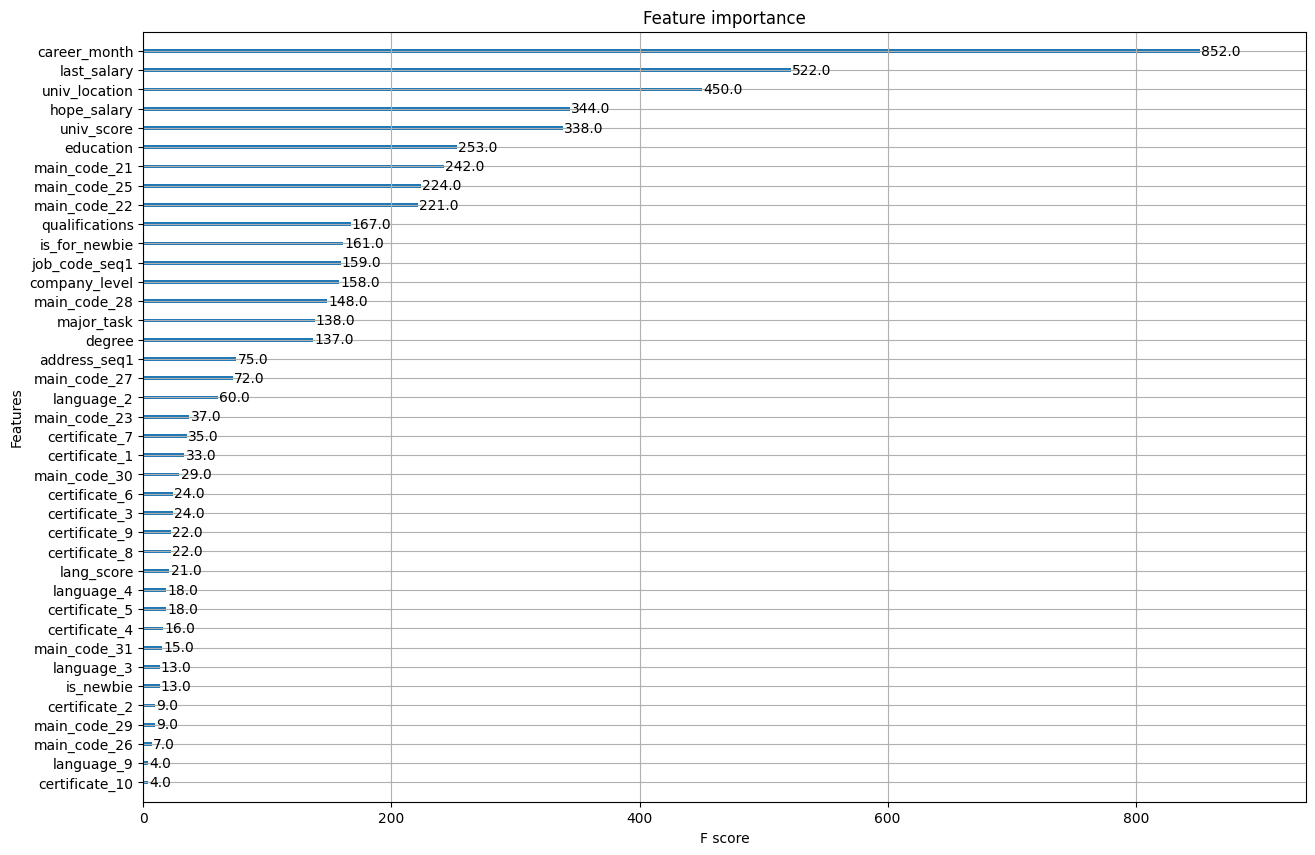

In [1049]:
fig, ax  = plt.subplots(figsize = (15,10))
plot_importance(modelV0,ax=ax)
plt.show()